In [1]:
# this file is a modified version of the original:
# https://www.kaggle.com/code/leonidkulyk/eda-ic-to-rgw-preprint-insights-vis

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;"> Google Research - ✈️ Identify Contrails to 🔥Reduce Global Warming - Exploratory Data Analysis</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Train ML models to identify contrails in satellite images and help prevent their formation</center></p>

***

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">(ಠಿ⁠_⁠ಠ) Overview</center>

<p style="font-family: consolas; font-size: 16px;">⚪ Contrails are clouds of ice crystals that form in aircraft engine exhaust. They can contribute to global warming by trapping heat in the atmosphere. Researchers have developed models to predict when contrails will form and how much warming they will cause. However, they need to validate these models with satellite imagery.
Your work will quantifiably improve the confidence in prediction of contrail forming regions and the techniques to avoid creating them. This will help airlines avoid creating contrails and reduce their impact on climate change.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Contrails, short for ‘condensation trails’, are line-shaped clouds of ice crystals that form in aircraft engine exhaust, and are created by airplanes flying through super humid regions in the atmosphere. Persistent contrails contribute as much to global warming as the fuel they burn for flights. </p>

<p style="font-family: consolas; font-size: 16px;">⚪ Google Research applies machine learning to opportunities to mitigate climate change and adapt to the changes we already see. They have run research projects in fusion energy plasma modeling, wildfire early detection, optimal car routing, and forecasts for climate disasters.</p>

<p style="text-align:center;"><img src="https://github.com/leo27heady/flask-basics/assets/45982614/b0930ea9-f0b3-4243-8eeb-bf0f6435f310" width="90%" height="90%"></p>

<p style="text-align:center; font-family: consolas; font-size: 16px;"><i>Image courtesy of Imperial College</i></p>


#### <a id="top"></a>
# <div style="box-shadow: rgb(60, 121, 245) 0px 0px 0px 3px inset, rgb(255, 255, 255) 10px -10px 0px -3px, rgb(31, 193, 27) 10px -10px, rgb(255, 255, 255) 20px -20px 0px -3px, rgb(255, 217, 19) 20px -20px, rgb(255, 255, 255) 30px -30px 0px -3px, rgb(255, 156, 85) 30px -30px, rgb(255, 255, 255) 40px -40px 0px -3px, rgb(255, 85, 85) 40px -40px; padding:20px; margin-right: 40px; font-size:30px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(60, 121, 245);"><b>Table of contents</b></div>

<div style="background-color: rgba(60, 121, 245, 0.03); padding:30px; font-size:15px; font-family: consolas;">
<ul>
    <li><a href="#0" target="_self" rel=" noreferrer nofollow">0. Import all dependencies</a></li>
    <li><a href="#1" target="_self" rel=" noreferrer nofollow">1. Data overview</a>
        <ul>
            <li><a href="#1.1" target="_self" rel=" noreferrer nofollow">1.1 Preprint insights</a></li>
        </ul>
    </li>
    <li><a href="#2" target="_self" rel=" noreferrer nofollow">2. train/ directory</a>
        <ul>
            <li><a href="#2.1" target="_self" rel=" noreferrer nofollow">2.1 Record 1000603527582775543</a></li>
            <li><a href="#2.1" target="_self" rel=" noreferrer nofollow">2.2 Record 1002294268041839364</a></li>
        </ul>
    </li>
    <li><a href="#3" target="_self" rel=" noreferrer nofollow">3. validation/ directory</a>
        <ul>
            <li><a href="#3.1" target="_self" rel=" noreferrer nofollow">3.1 Record 1049287742871594610</a></li>
        </ul>
    </li>
    <li><a href="#4" target="_self" rel=" noreferrer nofollow">4. test/ directory</a></li>
</ul>

</div>


<a id="0"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 0. Import all dependencies </b></div>

In [2]:
import os, sys
import math
from IPython import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class CFG:
    train_path: str = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/train"
    validation_path: str = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation"
    test_path: str = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/test"

In [4]:
def read_record(record_id, directory):
    record_data = {}
    for x in [
        "band_11", 
        "band_14", 
        "band_15", 
        "human_pixel_masks", 
        "human_individual_masks"
    ]:
        try:
            with open(os.path.join(directory, record_id, x + ".npy"), 'rb') as f:
                record_data[x] = np.load(f)
        except Exception as e:
            pass
    
    return record_data


def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])


def get_false_color(record_data):
    _T11_BOUNDS = (243, 303)
    _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
    _TDIFF_BOUNDS = (-4, 2)

    r = normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
    g = normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(record_data["band_14"], _T11_BOUNDS)
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    
    return false_color


def draw(i):
    im.set_array(false_color[..., i])
    return [im]

<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 1. Data overview</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ In this competition you will be using geostationary satellite images to identify aviation contrails.</p> 

<p style="font-family: consolas; font-size: 16px;">⚪ The original satellite images were obtained from the <a href="https://www.goes-r.gov/spacesegment/abi.html"><strong>GOES-16 Advanced Baseline Imager (ABI)</strong></a>, which is publicly available on <a href="https://console.cloud.google.com/storage/browser/gcp-public-data-goes-16/"><strong>Google Cloud Storage</strong></a>. The original full-disk images were reprojected using bilinear resampling to generate a local scene image.</p> 

<p style="font-family: consolas; font-size: 16px;">⚪ Because contrails are easier to identify with temporal context, a sequence of images at 10-minute intervals are provided. Each example (<code>record_id</code>) contains exactly one labeled frame. Temporal context refers to looking at the formation, persistence, and behavior of contrails over a period of time. </p> 


<p style="font-family: consolas; font-size: 16px;">🔴 Learn more about the dataset from the preprint: <a href="https://arxiv.org/abs/2304.02122"><strong>OpenContrails: Benchmarking Contrail Detection on GOES-16 ABI</strong></a>. </p>



<p style="font-family: consolas; font-size: 16px;">⚪ Labeling instructions can be found at in this supplementary material. Some key labeling guidance:</p>

* <p style="font-family: consolas; font-size: 16px;">Contrails must contain at least <b>10</b> pixels</p>
* <p style="font-family: consolas; font-size: 16px;">At some time in their life, Contrails must be at least <b>3x longer</b> than they are wide</p>
* <p style="font-family: consolas; font-size: 16px;">Contrails must either appear suddenly or enter from the sides of the image</p>
* <p style="font-family: consolas; font-size: 16px;">Contrails should be visible in at least <b>two</b> image</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Ground truth was determined by (generally) <b>4+</b> different labelers annotating each image. Pixels were considered a contrail when <b>>50%</b> of the labelers annotated it as such. Individual annotations (<code>human_individual_masks.npy</code>) as well as the aggregated ground truth annotations (<code>human_pixel_masks.npy</code>) are included in the training data. The validation data only includes the aggregated ground truth annotations.</p> 


<p style="font-family: consolas; font-size: 16px;">⚪ <code>{train|validation}_metadata.json</code> - metadata information for each record; contains the timestamps and the projection parameters to reproduce the satellite images.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>sample_submission.csv</code> - a sample submission file in the correct format.</p> 

## Advanced Baseline Imager(ABI) & Understanding Spectral Bands

The Advanced Baseline Imager (ABI) is an advanced weather satellite instrument used for Earth observation. It is one of the primary instruments onboard the Geostationary Operational Environmental Satellite (GOES) series, specifically designed for weather monitoring and forecasting. The ABI provides high-resolution, multi-channel imaging capabilities that significantly enhance weather analysis and forecasting capabilities.

**Spectral Bands:** The ABI has 16 spectral bands each designed to capture specific information about the Earth's atmosphere, clouds, land, and water. These bands cover a wide range of wavelengths, including visible, infrared, and near-infrared regions, hence why there are 16 bands in each example. ABI views the Earth with 16 different spectral bands (compared to five on the previous generation of GOES), including two visible channels, four near-infrared channels, and ten infrared channels.

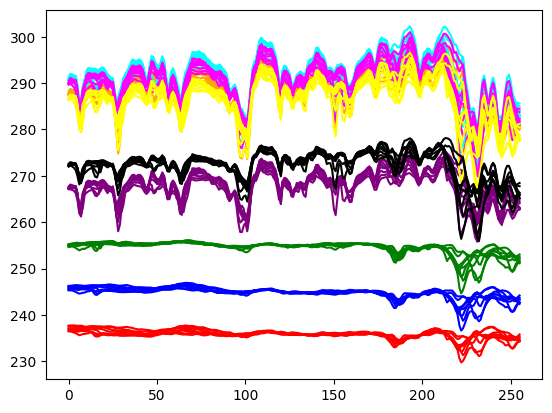

In [5]:
bands = ['08', '09', '10', '11', '12', '13', '14', '15', '16']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black']

for i, band in enumerate(bands):
    plot = np.load(f'/kaggle/input/google-research-identify-contrails-reduce-global-warming/train/1000216489776414077/band_{band}.npy')
    plt.plot(plot[0], color=colors[i], label=f'Band {band}')

## Understanding Spectral Bands

In the dataset, there are 9 bands for each example, and each band represents a series of images captured at different wavelengths of light. For instance, band 08 consists of a series of images highlighting a specific wavelength, while band 16 contains images capturing a different wavelength. It is important to note that each band contains images of the same thing just at different wavelengths so each band will look slightly different and contain more information than others because contrails look different at different wavelengths

These individual bands contain images taken at 10-minute intervals. There are 8 images in total for each band, taken across 80 minutes with a 10-minute interval between each image. When we examine band 8, for example, we are looking at a sequence of images, each taken 10 minutes after the previous one. This time series of images provides valuable information about the expansion and shape changes of contrails over time.

Now, let's discuss the segmentation masks. There are two files: human_pixel_masks and human_individual_masks. The human_individual_masks represent labels generated by multiple labellers. These labels are then compared and combined to create a final ground truth, which can be found in the human_pixel_masks file. This mask corresponds to the 5th image in the bands. The purpose of this approach is to enhance the accuracy of the ground truth. By involving multiple labellers and aggregating their findings, we can achieve a more precise and reliable ground truth. To draw an analogy, just as a group of doctors can collectively provide a more accurate assessment of a disease, multiple labellers collaborating on the labels can produce a more accurate ground truth.

### Plotting So We Can Visualize Our Understanding

As we can see in the plot as you go across from the left to the right you are seeing the different spectral bands we are looking at, and as you go down you see the image at different time steps (10 minutes apart). The human pixel mask (ground truth) corresponds to the image at time step 5. 

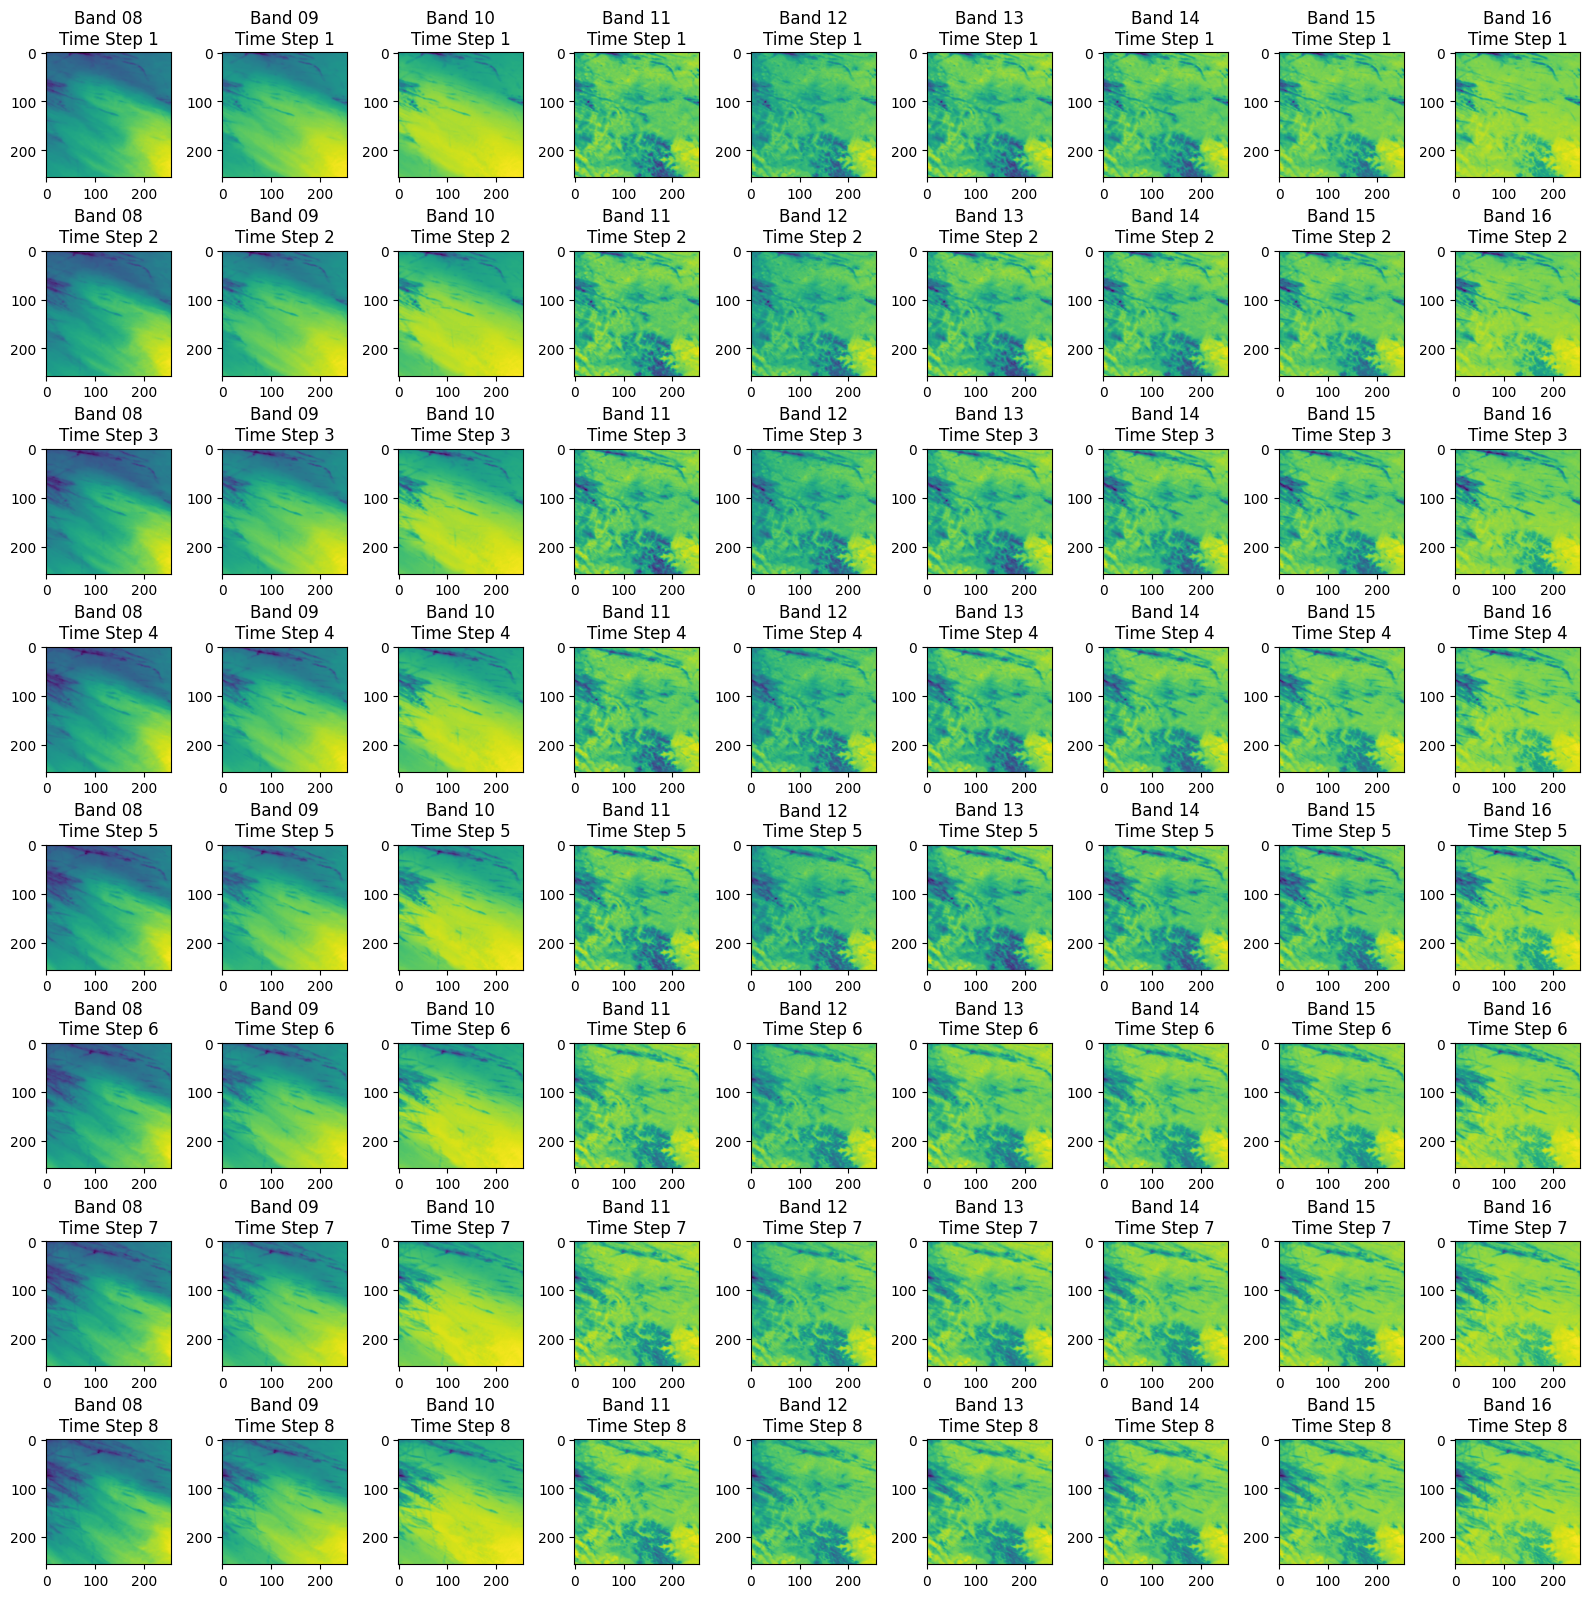

In [6]:
# https://www.kaggle.com/code/pranavnadimpali/comprehensive-eda-submission
def plot_example(example_id, split_dir):
    """
    Args: 
        example_id(str): The id of the example i.e. '1000216489776414077'
        split_dir(str): The split directoryu i.e. 'test', 'train', 'val'
    """
    fig, axs = plt.subplots(8, len(bands), figsize=(16, 16)) 

    for j, band in enumerate(bands):
        img = np.load(CFG.train_path + f"/{example_id}/band_{band}.npy")
        for i in range(8):
            axs[i, j].imshow(img[..., i]) 
            axs[i, j].set_title(f"Band {band}\nTime Step {i+1}") 

    plt.tight_layout()  
    plt.show()
    
plot_example('1000603527582775543', 'train')

## Checking Out The Masks

As we can see the human individual masks contains 4  (256, 256, 1) masks. These 4 masks corresponding to the masks created by 4 labellers. Although there are 4 in this example other examples can have a varying amount. The human pixel masks are the ground truth and there is only one mask of shape (256, 256, 1). This should be expected because the input images are of shape 256 x 256 so we should expect the output shape to be the same


In [7]:
masks = np.load("/kaggle/input/google-research-identify-contrails-reduce-global-warming/train/1000216489776414077/human_individual_masks.npy")
ground_truth = np.load("/kaggle/input/google-research-identify-contrails-reduce-global-warming/train/1000216489776414077/human_pixel_masks.npy")

print(f"The human individual masks has shape {masks.shape}")
print(f"The human pixel masks has shape {ground_truth.shape}")

The human individual masks has shape (256, 256, 1, 4)
The human pixel masks has shape (256, 256, 1)


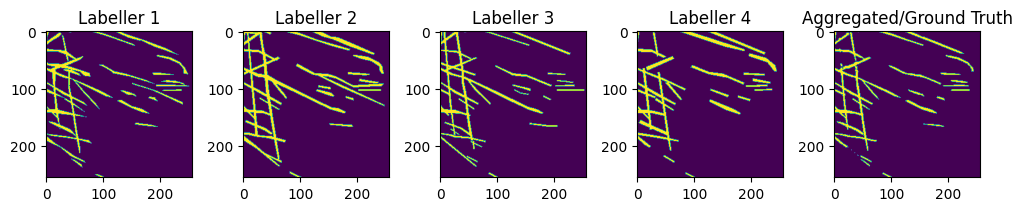

In [8]:
# https://www.kaggle.com/code/pranavnadimpali/comprehensive-eda-submission
def plot_masks(example_id, split_dir):
    """
    Args:
        example_id(str): The id of the example i.e. '1000216489776414077'
        split_dir(str): The split directoryu i.e. 'test', 'train', 'val'
    """
    masks = np.load(CFG.train_path + f"/{example_id}/human_individual_masks.npy")
    ground_truth = np.load(CFG.train_path + f"/{example_id}/human_pixel_masks.npy")

    fig, axs = plt.subplots(1, len(masks[0,0,0]) + 1, figsize=(2 * (len(masks[0,0,0]) + 1), 16)) 

    for i in range(len(masks[0,0,0])):
        axs[i].imshow(masks[..., i])
        axs[i].set_title(f"Labeller {i+1}")

    axs[i+1].imshow(ground_truth)
    axs[i+1].set_title("Aggregated/Ground Truth")

    plt.tight_layout() 
    plt.show()

plot_masks('1000603527582775543', 'train')

<a id="1.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.1 Preprint insights</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ The full dataset contains <b>20,544</b> examples in the train set and <b>1,866</b> examples in the validation set. The examples are randomly partitioned except for the satellites scenes that were identified as likely to have contrails by Google Street View, which are only included in the training set. <b>9,283</b> of the training examples contain at least <b>one annotated contrail</b>. About <b>1.2%</b> of the pixels in the training set are labeled as contrails.</p>

<p style="font-family: consolas; font-size: 16px;">🔴 Models aren't publicly available. For more information proceed to the preprint: <a href="https://arxiv.org/abs/2304.02122"><strong>OpenContrails: Benchmarking Contrail Detection on GOES-16 ABI</strong></a>. </p>



<a id="2"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 2. <code>train/</code> directory</b></div>


<p style="font-family: consolas; font-size: 16px;">⚪ This is the training set; each folder represents a record_id and contains the following data:</p>

* <p style="font-family: consolas; font-size: 16px;"><code>band_{08-16}.npy</code>: array with size of <code>H x W x T</code>, where <code>T = n_times_before + n_times_after + 1</code>, representing the number of images in the sequence. There are <code>n_times_before</code> and <code>n_times_after</code> images before and after the labeled frame respectively. In our dataset all examples have <code>n_times_before=4</code> and <code>n_times_after=3</code>. Each band represents an infrared channel at different wavelengths and is converted to brightness temperatures based on the calibration parameters. The number in the filename corresponds to the GOES-16 ABI band number. Details of the ABI bands can be found here.</p>
* <p style="font-family: consolas; font-size: 16px;"><code>human_individual_masks.npy</code>: array with size of <code>H x W x 1 x R</code>. Each example is labeled by R individual human labelers. R is not the same for all samples. The labeled masks have value either 0 or 1 and correspond to the (<code>n_times_before+1</code>)-th image in <code>band_{08-16}.npy</code>. They are available only in the training set.</p>
* <p style="font-family: consolas; font-size: 16px;"><code>human_pixel_masks.npy</code>: array with size of <code>H x W x 1</code> containing the binary ground truth. A pixel is regarded as contrail pixel in evaluation if it is labeled as contrail by more than half of the labelers.</p>

## False Color Images

We know that the image labellers are putting their final annotations on the image at time step 5 (the fifth element) in each band. However, the image that the labellers end up annotating is not found in the spectral bands given to use but rather a false color image. A false color image is a image that can be generated from the spectral bands given to us and it is meant to make contrails appear dark relative to their surroundings making them easier to detect. This false color image is what the labelers ended up using to derive their ground truths. 

The false color images are generated using the **ash color scheme**. Here is a brief overview of the color scheme

The **ash color scheme** is a false color representation commonly used for visualizing volcanic ash plumes or volcanic cloud observations. It employs a three-channel color scheme (red, green, and blue) to highlight specific features of interest:

- **Red Channel**: Represents the temperature or thermal information of the volcanic plume, with warmer regions shown in red/orange and cooler regions in shades of blue/green.

- **Green Channel**: Indicates the particle size or density of volcanic ash particles in the plume. Darker green indicates denser or larger particles, while lighter green represents finer particles.

- **Blue Channel**: Provides additional information about the plume, such as its height or altitude. Higher blue values suggest greater plume altitude, while darker shades imply lower altitudes.

By combining these color channels, the ash color scheme enhances the visibility of different properties within the volcanic plume, facilitating analysis and interpretation of volcanic cloud data.

Although it is commonly used to study volcanic activity it is also useful for identifying contrails


<a id="2.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 2.1 Record <code>1000603527582775543</code></b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's consider record 1000603527582775543. First need to load it.</p>

In [9]:
N_TIMES_BEFORE = 4
record_id = "1000603527582775543"

record_data = read_record(record_id, CFG.train_path)

<p style="font-family: consolas; font-size: 16px;">⚪ Next step is combining bands into a false color image.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ In order to view contrails in GOES, we use the "ash" color scheme.  In this color scheme, contrails appear in the image as dark blue.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Note that we use a modified version of the ash color scheme here, developed by Kulik et al., which uses slightly different bands and bounds tuned for contrails.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ References:</p>

* <p style="font-family: consolas; font-size: 16px;"><a href="https://rammb.cira.colostate.edu/training/visit/quick_guides/GOES_Ash_RGB.pdf"><strong>Original Ash RGB description</strong></a></p>
* <p style="font-family: consolas; font-size: 16px;"><a href="https://dspace.mit.edu/handle/1721.1/124179?show=full"><strong>Modified Ash Color Scheme (Kulik et al., page 22)</strong></a></p>

In [10]:
false_color = get_false_color(record_data)

<p style="font-family: consolas; font-size: 16px;">⚪ Let's plot false color image with ground truth contrail mask. As mentioned earlier pixels are considering as a contrail when >50% of the labelers annotated it as such.</p>

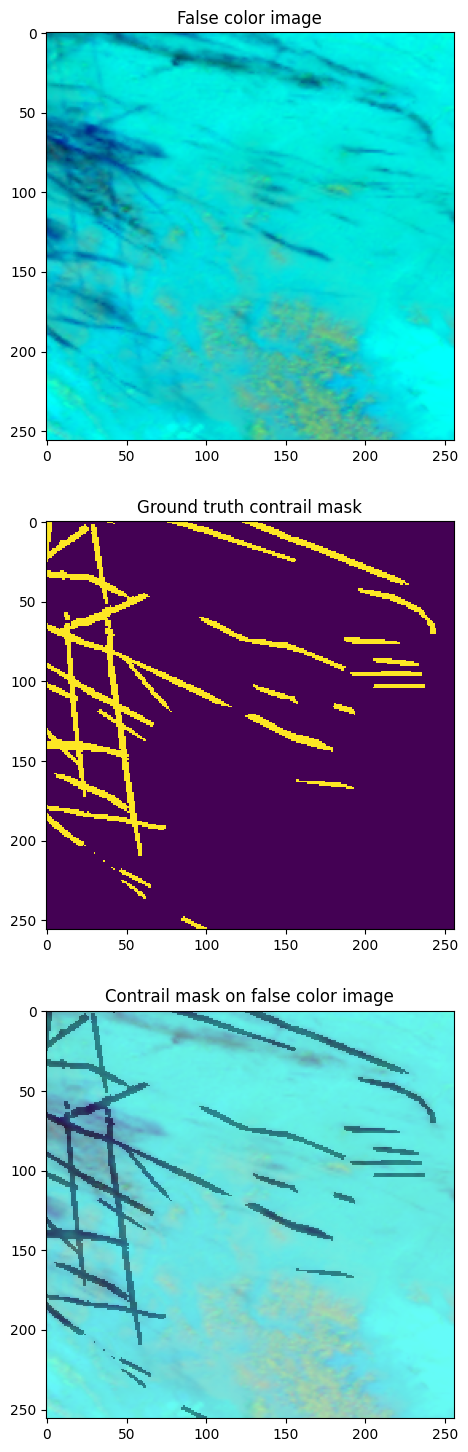

In [11]:
# false_color.shape => (256,256,3,8)
img = false_color[..., N_TIMES_BEFORE]
# img.shape => (256,256,3)


plt.figure(figsize=(6, 18))
ax = plt.subplot(3, 1, 1)
ax.imshow(img)
ax.set_title("False color image")

ax = plt.subplot(3, 1, 2)
ax.imshow(record_data["human_pixel_masks"], interpolation="none")
ax.set_title("Ground truth contrail mask")

ax = plt.subplot(3, 1, 3)
ax.imshow(img)
ax.imshow(record_data["human_pixel_masks"], cmap="Reds", alpha=.4, interpolation="none")
ax.set_title("Contrail mask on false color image");

<p style="font-family: consolas; font-size: 16px;">⚪ Ground truth was determined by (generally) 4+ different labelers annotating each image. So we can easily plot these masks.</p>

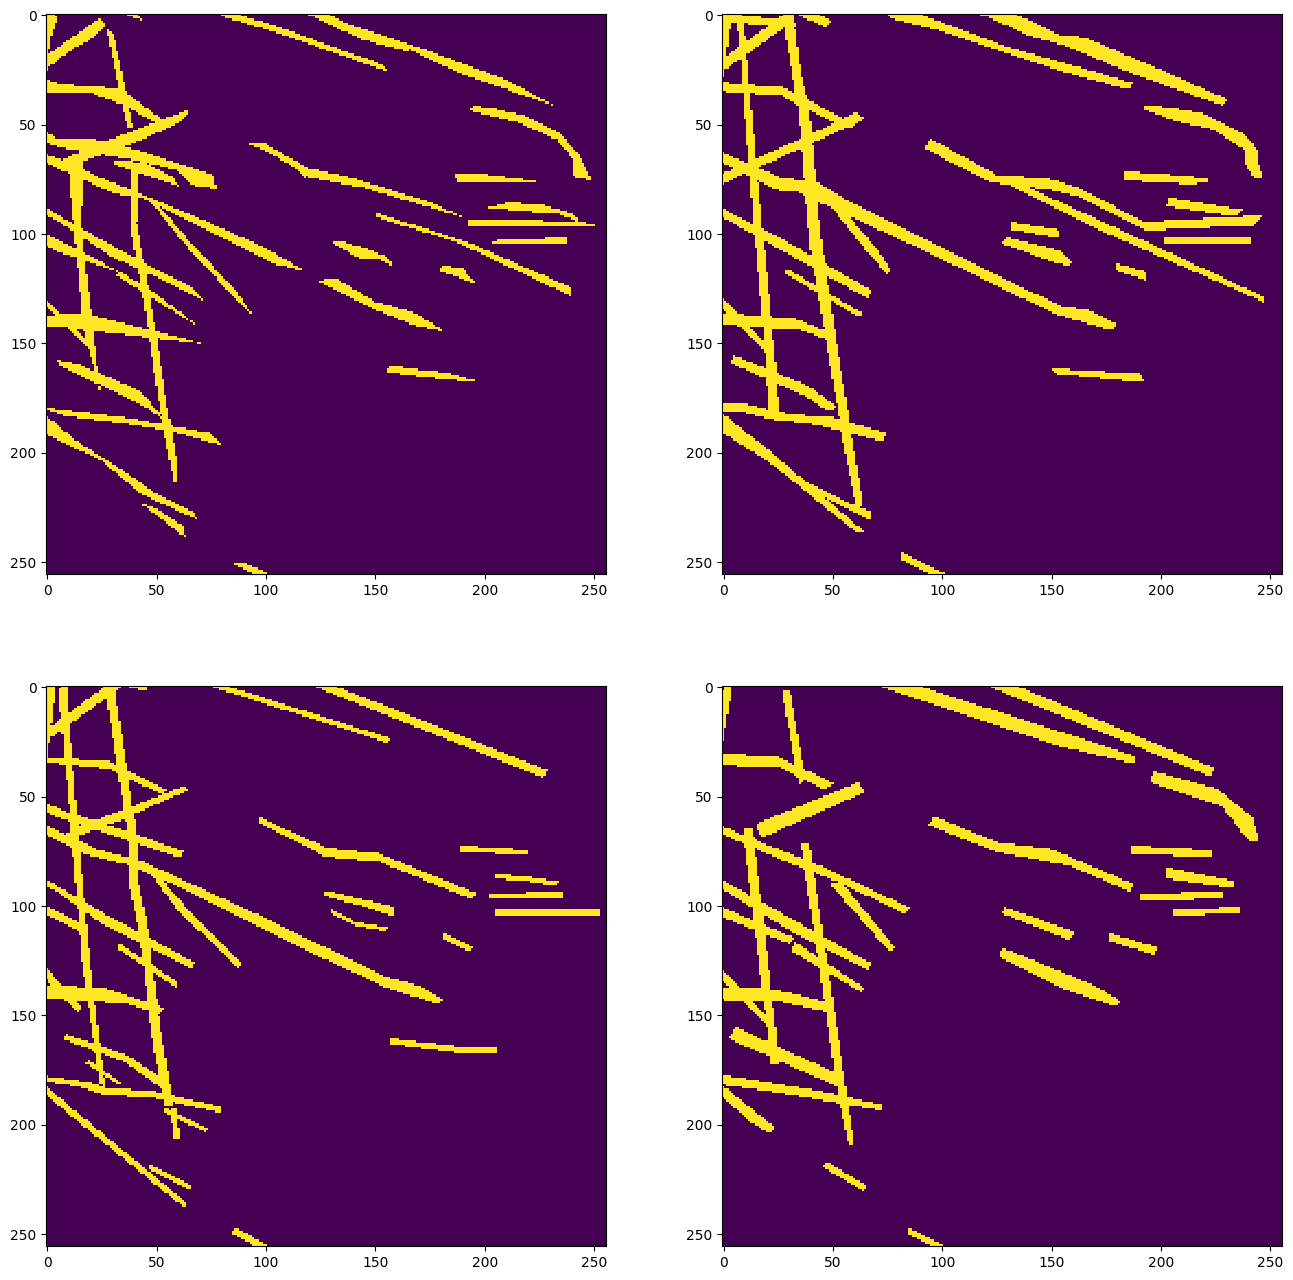

In [12]:
# Individual human masks
count = record_data["human_individual_masks"].shape[-1]

m = math.ceil(record_data["human_individual_masks"].shape[-1] / 2)
n = 2
plt.figure(figsize=(n*8, m*8))
for i in range(count):
    plt.subplot(m, n, i+1)
    plt.imshow(record_data["human_individual_masks"][..., i], interpolation="none")

<p style="font-family: consolas; font-size: 16px;">⚪ Now let's see the record data in action.</p>

In [13]:
# # Animation
# fig = plt.figure(figsize=(6, 6))
# im = plt.imshow(false_color[..., 0])

# anim = animation.FuncAnimation(
#     fig, draw, frames=false_color.shape[-1], interval=500, blit=True
# )
# plt.close()
# display.HTML(anim.to_jshtml())

In [14]:
df_train_idx = pd.DataFrame({'idx': os.listdir('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train')})

In [15]:
# https://www.kaggle.com/code/mnokno/getting-started-eda-model-train-submit
train_images_with_contrails = 0
train_images_without_contrails = 0
train_contrail_pixel_count = 0
train_non_contrail_pixel_count = 0
train_contrail_pixel_count_conly = 0
train_non_contrail_pixel_count_conly = 0
img_pixel_count = 256 * 256

data_dir: str = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'

def get_mask_image(idx: str, parrent_folder: str) -> np.array:
    return np.load(os.path.join(data_dir, parrent_folder, idx, 'human_pixel_masks.npy')) 

for idx in df_train_idx['idx']:
    mask = get_mask_image(idx, 'train')
    contrail_pixel_count = np.sum(mask > 0)
    
    if contrail_pixel_count > 0:
        train_images_with_contrails += 1
        train_contrail_pixel_count_conly += contrail_pixel_count
        train_non_contrail_pixel_count_conly += (img_pixel_count - contrail_pixel_count)
    else:
        train_images_without_contrails += 1
        
    train_contrail_pixel_count += contrail_pixel_count
    train_non_contrail_pixel_count += (img_pixel_count - contrail_pixel_count)


In [16]:
validation_images_with_contrails = 0
validation_images_without_contrails = 0
validation_contrail_pixel_count = 0
validation_non_contrail_pixel_count = 0
validation_contrail_pixel_count_conly = 0
validation_non_contrail_pixel_count_conly = 0
img_pixel_count = 256 * 256

df_validation_idx = pd.DataFrame({'idx': os.listdir('/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation')})

for idx in df_validation_idx['idx']:
    mask = get_mask_image(idx, 'validation')
    contrail_pixel_count = np.sum(mask > 0)
    
    if contrail_pixel_count > 0:
        validation_images_with_contrails += 1
        validation_contrail_pixel_count_conly += contrail_pixel_count
        validation_non_contrail_pixel_count_conly += (img_pixel_count - contrail_pixel_count)
    else:
        validation_images_without_contrails += 1
        
    validation_contrail_pixel_count += contrail_pixel_count
    validation_non_contrail_pixel_count += (img_pixel_count - contrail_pixel_count)


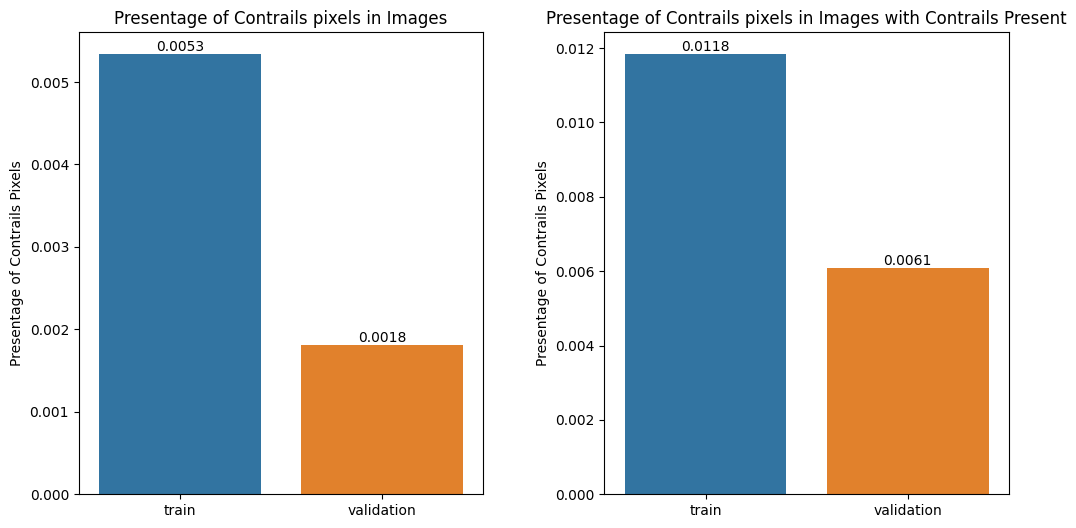

In [17]:
# https://www.kaggle.com/code/mnokno/getting-started-eda-model-train-submit

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.3)
axes = axes.flatten()

train_with_contrails_pix = train_contrail_pixel_count / (train_contrail_pixel_count + train_non_contrail_pixel_count)
validation_with_contrails_pix = validation_contrail_pixel_count / (validation_contrail_pixel_count + validation_non_contrail_pixel_count)
data = pd.DataFrame({'Data': [train_with_contrails_pix, validation_with_contrails_pix],
        'Data Set': ['train', 'validation']})
sns.barplot(data=data, y='Data', x="Data Set", orient='v', ax=axes[0])
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
axes[0].set_xlabel('')
axes[0].set_ylabel('Presentage of Contrails Pixels')
axes[0].set_title('Presentage of Contrails pixels in Images')

train_with_contrails_pix_conly = train_contrail_pixel_count_conly / (train_contrail_pixel_count_conly + train_non_contrail_pixel_count_conly)
validation_with_contrails_pix_conly = validation_contrail_pixel_count_conly / (validation_contrail_pixel_count_conly + validation_non_contrail_pixel_count_conly)
data = pd.DataFrame({'Data': [train_with_contrails_pix_conly, validation_with_contrails_pix_conly],
        'Data Set': ['train', 'validation']})
sns.barplot(data=data, y='Data', x="Data Set", orient='v', ax=axes[1])
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
axes[1].set_xlabel('')
axes[1].set_ylabel('Presentage of Contrails Pixels')
axes[1].set_title('Presentage of Contrails pixels in Images with Contrails Present')

plt.show()

<a id="3"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 3. <code>validation/</code> directory</b></div>

<p style="font-family: consolas; font-size: 16px;">🔴 This is the same as the training set, without the individual label annotations; it is permitted to use this as training data if desired</p>

<a id="3.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 3.1 Record <code>1049287742871594610</code></b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's consider record 1000834164244036115. First need to load it.</p>

In [18]:
N_TIMES_BEFORE = 4
record_id = "1049287742871594610"

record_data = read_record(record_id, CFG.validation_path)

<p style="font-family: consolas; font-size: 16px;">⚪ Next step is combining bands into a false color image.</p>

In [19]:
false_color = get_false_color(record_data)

<p style="font-family: consolas; font-size: 16px;">⚪ Let's plot false color image with ground truth contrail mask. As mentioned earlier pixels are considering as a contrail when >50% of the labelers annotated it as such.</p>

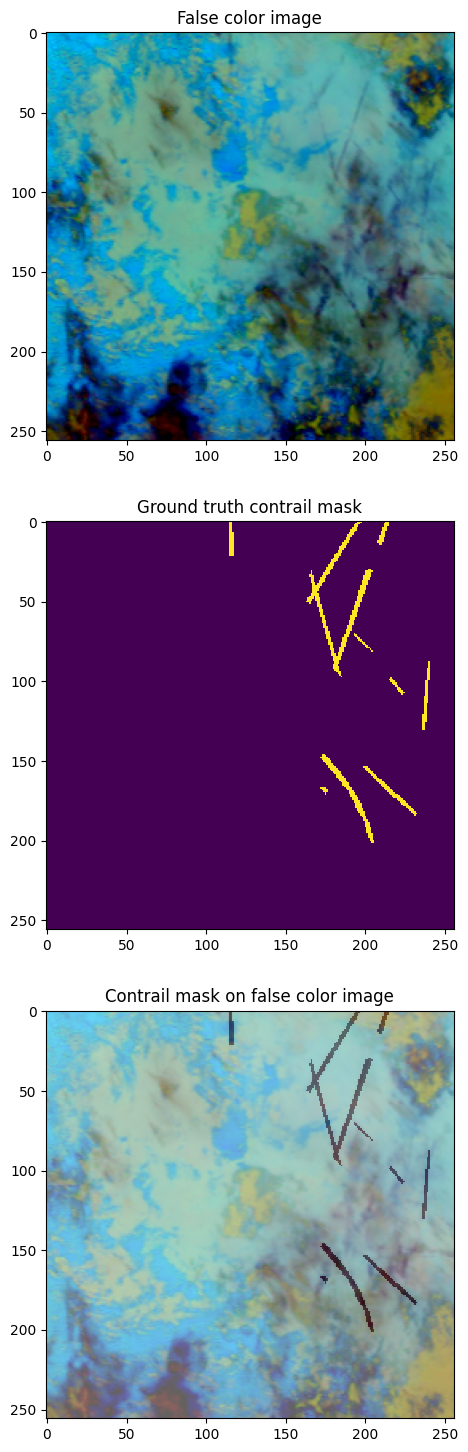

In [20]:
img = false_color[..., N_TIMES_BEFORE]

plt.figure(figsize=(6, 18))
ax = plt.subplot(3, 1, 1)
ax.imshow(img)
ax.set_title("False color image")

ax = plt.subplot(3, 1, 2)
ax.imshow(record_data["human_pixel_masks"], interpolation="none")
ax.set_title("Ground truth contrail mask")

ax = plt.subplot(3, 1, 3)
ax.imshow(img)
ax.imshow(record_data["human_pixel_masks"], cmap="Reds", alpha=.4, interpolation="none")
ax.set_title("Contrail mask on false color image");

<a id="4"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 4. <code>test/</code> directory</b></div>

<p style="font-family: consolas; font-size: 16px;">🔴 This is the test set; our objective is to identify contrails found in these records. <b>Note</b>: Since this is a Code competition, you do not have access to the actual test set that your notebook is rerun against. The records shown here are copies of the first two records of the validation data (without the labels). The hidden test set is approximately the same size (± 5%) as the validation set. <b>IMPORTANT</b>: Submissions should use <code>run-length encoding</code> with empty predictions (e.g., no contrails) should be marked by <code>'-'</code> in the submission. (See this <a href="https://www.kaggle.com/code/inversion/contrails-rle-submission"><strong>notebook</strong></a> for details.)</p>

In [21]:
!ls $CFG.test_path

1000834164244036115  1002653297254493116


In [22]:
!stat $CFG.test_path

  File: /kaggle/input/google-research-identify-contrails-reduce-global-warming/test
  Size: 0         	Blocks: 0          IO Block: 16384  directory
Device: 38h/56d	Inode: 19534235813  Links: 4
Access: (0755/drwxr-xr-x)  Uid: (65534/  nobody)   Gid: (65534/ nogroup)
Access: 2023-05-10 15:10:23.068458733 +0000
Modify: 2023-05-10 15:10:23.576321649 +0000
Change: 2023-05-10 15:10:23.576321649 +0000
 Birth: -


In [23]:
# (⁠ ⁠ꈍ⁠ᴗ⁠ꈍ⁠) WORK STILL IN PROGRESS

# <div style="box-shadow: rgba(240, 46, 170, 0.4) -5px 5px inset, rgba(240, 46, 170, 0.3) -10px 10px inset, rgba(240, 46, 170, 0.2) -15px 15px inset, rgba(240, 46, 170, 0.1) -20px 20px inset, rgba(240, 46, 170, 0.05) -25px 25px inset; padding:20px; font-size:30px; font-family: consolas; display:fill; border-radius:15px; color: rgba(240, 46, 170, 0.7)"> <b> ༼⁠ ⁠つ⁠ ⁠◕⁠‿⁠◕⁠ ⁠༽⁠つ Thank You!</b></div>

<p style="font-family:verdana; color:rgb(34, 34, 34); font-family: consolas; font-size: 16px;"> 💌 Thank you for taking the time to read through my notebook. I hope you found it interesting and informative. If you have any feedback or suggestions for improvement, please don't hesitate to let me know in the comments. <br><br> 🚀 If you liked this notebook, please consider upvoting it so that others can discover it too. Your support means a lot to me, and it helps to motivate me to create more content in the future. <br><br> ❤️ Once again, thank you for your support, and I hope to see you again soon!</p>